# Combined spectra_example 

# import 

In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lineid_plot
from ramandecompy import spectrafit
from ramandecompy import peakidentify
from ramandecompy import dataprep
from ramandecompy import datavis
from ramandecompy import dataimport
from ramandecompy import machine_learning
from scipy import interpolate

In [2]:
dataprep.new_hdf5('combined_calibration_dataset')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/water.xlsx', 'water')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx', 'hydrogen')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx', 'methane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx', 'carbon monoxide')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/CO2_100wt%.csv', 'carbon dioxide')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/sapphire.xlsx', 'sapphire')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Propane_test.xlsx', 'Propane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Ethane_test.xlsx', 'Ethane')
dataprep.add_calibration('combined_calibration_dataset.hdf5', '../ramandecompy/tests/test_files/Acetaldehyde_test.xlsx', 'Acetaldehyde')

Data from ../ramandecompy/tests/test_files/water.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Methane_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/CO2_100wt%.csv fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/sapphire.xlsx fit with compound pseudo-Voigt model. Results saved to combined_calibration_dataset.hdf5.
Data from ../ramandecompy/tests/test_files/Propane_t

[[array([0.00063043, 0.00064964, 0.00067524, ..., 0.12447342, 0.12084528,
         0.11732835]),
  array([0.00039862, 0.00040691, 0.00041796, ..., 0.05854445, 0.05685952,
         0.05522572]),
  array([0.0005668 , 0.00058407, 0.00060807, ..., 0.19989903, 0.19407428,
         0.18842073]),
  array([0.00069615, 0.00071241, 0.00073591, ..., 0.24322461, 0.23617477,
         0.22933019]),
  array([0.00026064, 0.00027858, 0.0003058 , ..., 0.11144903, 0.10820108,
         0.10506093]),
  array([0.00044007, 0.00044531, 0.00045196, ..., 0.07334609, 0.07124441,
         0.06920205]),
  array([0.00074136, 0.00077138, 0.00081395, ..., 0.23710823, 0.2301989 ,
         0.2235026 ]),
  array([0.00054124, 0.0005527 , 0.00056774, ..., 0.15020711, 0.14584369,
         0.14160511]),
  array([0.00031221, 0.0003253 , 0.00034362, ..., 0.04563123, 0.04430114,
         0.04301814]),
  array([0.00024027, 0.00026576, 0.00030527, ..., 0.09611019, 0.09331377,
         0.09062347])],
 [array([0.00080549, 0.000837

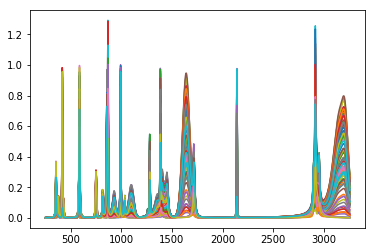

In [7]:
# first a function that will return a normalized interpolated spectra
target_compound = 'water'
# compound = 'water'
hdf5_filename = 'combined_calibration_dataset.hdf5'
spectra_count = 10
hdf5 = h5py.File(hdf5_filename, 'r')
# get list of compounds from hdf5 file
y_data_list = []
compound_list = list(hdf5.keys())
for target_compound in compound_list:
    x_data, y_data, labels = machine_learning.generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
    y_data_list.append(y_data)
len(x_data)
y_data_list

In [8]:
from sklearn.model_selection import train_test_split

# divide and extract test/train and validation data

X_train, X_test, y_train, y_test = train_test_split(y_data, labels, test_size=0.2)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

8 8
2 2


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

# get predictions
Z = logreg.predict(X_test)

logreg.score(X_test, y_test)

1.0

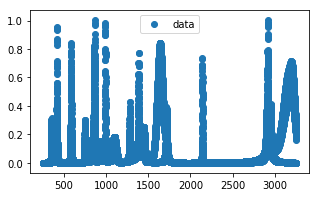

In [10]:



fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(x_data, y_data, label='data')
# ax.scatter(X_train, y_train, label='train')
# ax.scatter(X_test, y_test, label='teste')
# ax.scatter(X_test, regr.predict(X_test), label='predicted')

# fig, ax = plt.subplots(figsize=(5, 3))
# y = dat['fraction'].values
# x = dat['height'].values
# # Create the linear regression model
# LogRegr = linear_model.LogisticRegression() 
# # plotting the balance
# ax.scatter(dat['height'], dat['fraction'], label = 'balance default',color='r')

# # fit the linear model 
# LogRegr.fit(x.reshape(-1,1),y.reshape(-1,1))
# xres = np.array(x).reshape(-1,1)
# plt.plot(x,LogRegr.predict_proba(xres)[:,1],'o',label = 'fit')
# # Find the coefficients B0 and B1
# print('B0, B1: ',LogRegr.intercept_, LogRegr.coef_[0])
# ax.set_ylabel('Probability Default')
# ax.set_xlabel('Balance')
# ax.set_title('Probability Default vs. Balance')
plt.legend()

In [11]:
dataprep.new_hdf5('combined_calibration_cal')

In [12]:
hdf5_calfilename = 'combined_calibration_cal.hdf5' #update to hdf5_calfilename
key = 'cal'
for num, label in enumerate(labels):
    machine_learning.combine_experiment(hdf5_calfilename, key, x_data, y_data, label, num)

cal/0/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/1/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/2/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/3/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/4/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/5/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/6/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/7/residuals
Data from fit with compound pseudo-Voigt model.
          Results saved to combined_calibration_cal.hdf5.
cal/8/residuals
Data fro

In [13]:
dataprep.view_hdf5(hdf5_calfilename)

**** combined_calibration_cal.hdf5 ****
cal
|    0
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    Peak_19
|    |    Peak_20
|    |    counts
|    |    residuals
|    |    wavenumber
|    1
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    counts
|    |    residuals
|    |    wavenumber
|    2
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |   

In [14]:
hdf5 = h5py.File(hdf5_calfilename, 'r+')

In [15]:
key_list = machine_learning.keyfinder(hdf5_calfilename)
key_list

['cal/0',
 'cal/1',
 'cal/2',
 'cal/3',
 'cal/4',
 'cal/5',
 'cal/6',
 'cal/7',
 'cal/8',
 'cal/9']

In [16]:
hdf5_calfilename = 'combined_calibration_dataset.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'combined_calibration_cal.hdf5'
frames = []
for i,key in enumerate(key_list):
    df =peakidentify.peak_assignment(hdf5_expfilename, key, hdf5_calfilename, 50, plot =False)
    frames.append(df)

The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
The peaks that we found for Propane are: 
870.1669869869869
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for carbon dioxide are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
The peaks that we found for carbon monoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The peaks that we found for hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
1035.6547747747748
[1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for 

The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1.]
The peaks that we found for Ethane are: 
993.5306106106106
2898.1446046046044
2952.3042442442443
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
The peaks that we found for Propane are: 
870.1669869869869
[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for carbon dioxide are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
The peaks that we found for carbon monoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
The peaks that we found for hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
1035.6547747747748
[1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for methane are: 
2916

(0.12546293267480324, 4.309624548170463, 2141.0, 5.514525295975616, 8.619249096340926, 0.5767371012371217, 5.513171153171368, "['carbon monoxide']")
(0.9999999995479414, 5.74920025907773, 2915.0, 16.8424142308532, 11.49840051815546, 0.9324961240602083, 16.740199738536024, "['Acetaldehyde', 'Ethane', 'methane']")
(0.5615009108380823, 7.15741498683837, 2952.0, 3.4787741363207854, 14.31482997367674, 0.18697994496734932, 3.462441972254386, "['Acetaldehyde', 'Ethane', 'methane']")
(0.6416992337501831, 98.96445610679152, 3194.0, 167.35209901803051, 197.92891221358303, 0.6300106123017555, 117.35869828295249, "['water']")
{'Acetaldehyde': 62.5, 'Ethane': 133.33333333333331, 'Propane': 100.0, 'carbon dioxide': 100.0, 'carbon monoxide': 100.0, 'hydrogen': 150.0, 'methane': 200.0, 'sapphire': 125.0, 'water': 100.0}
The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.23

(0.9629463715782992, 9.370012226759304, 1715.0, 9.782989019355119, 18.740024453518608, 0.3381966850109116, 9.745552413832911, "['Acetaldehyde']")
(4.429734357103143e-12, 4.291275454649878, 2141.0, 1.1064407983451585, 8.582550909299757, 0.1211098825539, 1.106440798345149, "['carbon monoxide']")
(1.0, 13.34037987879426, 2915.0, 23.535221590476073, 26.68075975758852, 0.5615652458055665, 23.203918072638768, "['Acetaldehyde', 'Ethane', 'methane']")
(0.8778409411545984, 99.18374331660304, 3194.0, 126.343025240192, 198.36748663320608, 0.4290326916347806, 85.54576523916938, "['water']")
{'Acetaldehyde': 125.0, 'Ethane': 66.66666666666666, 'Propane': 200.0, 'carbon dioxide': 150.0, 'carbon monoxide': 100.0, 'hydrogen': 150.0, 'methane': 100.0, 'sapphire': 125.0, 'water': 100.0}
The peaks that we found for Acetaldehyde are: 
858.1315115115115
930.3443643643643
1098.8410210210209
1354.5948748748747
1402.7367767767767
1450.8786786786784
1715.659139139139
2928.233293293293
[0. 0. 0. 0. 0. 1. 1. 1. 

(9.43689570931383e-16, 8.631621565203528, 1450.0, 1.4874827154219403, 17.263243130407055, 0.08094636122151433, 1.4874827154219405, "['Acetaldehyde']")
(8.620493208155722e-12, 40.82017401615959, 1640.0, 63.90869915280052, 81.64034803231918, 0.7353988054216442, 63.90869915279096, "['water']")
(0.8704420130461632, 9.53830129965411, 1715.0, 6.506281540464406, 19.07660259930822, 0.2305066986068088, 6.483371483582255, "['Acetaldehyde']")
(0.13425059000201, 4.308257485247891, 2141.0, 6.555123216709069, 8.616514970495782, 0.6837612307153457, 6.5534013474337245, "['carbon monoxide']")
(0.9999998172324117, 9.013889273806273, 2915.0, 17.94436054200388, 18.027778547612545, 0.633674065082182, 17.77363943886387, "['Acetaldehyde', 'Ethane', 'methane']")
(1.0, 12.633254018832933, 2952.0, 7.07693631477156, 25.266508037665865, 0.17831184186803617, 6.972532191445736, "['Acetaldehyde', 'Ethane', 'methane']")
(0.7167202399796159, 93.49628629380932, 3194.0, 155.09335919656024, 186.99257258761864, 0.59916673

(0.018455453611187278, 4.350070806401254, 2141.0, 1.2765932933290633, 8.700141612802508, 0.13702592087593776, 1.276546748114178, "['carbon monoxide']")
(5.901703592214869e-06, 3.8104527914027218, 2899.0, 1.079514570298306, 7.6209055828054435, 0.13307267620307775, 1.0795145456747706, "['Acetaldehyde', 'Ethane', 'methane']")
(1.0, 11.65393551300226, 2915.0, 21.8757628840328, 23.30787102600452, 0.597503872063748, 21.606719554592882, "['Acetaldehyde', 'Ethane', 'methane']")
(1.0, 11.186267394287967, 2952.0, 10.434445146058028, 22.372534788575933, 0.2969164717561405, 10.298124838188725, "['Acetaldehyde', 'Ethane', 'methane']")
(0.4759187747932863, 99.99999999999997, 3194.0, 118.23774624658002, 199.99999999999994, 0.4701846604453872, 84.6610489686683, "['water']")
{'Acetaldehyde': 137.5, 'Ethane': 166.66666666666669, 'Propane': 100.0, 'carbon dioxide': 150.0, 'carbon monoxide': 100.0, 'hydrogen': 150.0, 'methane': 300.0, 'sapphire': 75.0, 'water': 100.0}


In [17]:
result = pd.concat(frames,axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [18]:
result

,0,1,2,3,4,5,6,7
0,0.697096,4.40416,355,1.42559,8.80832,0.117879,1.41172,"['hydrogen', 'sapphire']"
0,5.22898e-06,3.98582,379,0.510889,7.97165,0.0602068,0.510889,"['hydrogen', 'sapphire']"
0,0.726365,3.65095,417,4.69566,7.3019,0.46268,4.67039,['sapphire']
0,0.968782,4.76531,587,4.65353,9.53062,0.315459,4.63061,"['hydrogen', 'sapphire']"
0,0.00088554,6.88349,750,2.0925,13.767,0.142748,2.09249,['sapphire']
0,0.476755,3.85273,815,0.573463,7.70547,0.0591712,0.572731,"['Acetaldehyde', 'hydrogen']"
0,0.389551,8.88003,860,17.519,17.7601,0.810323,17.4792,"['Acetaldehyde', 'Propane', 'hydrogen']"
0,0.982913,16.7779,929,7.51721,33.5559,0.143775,7.44206,['Acetaldehyde']
0,0.70899,3.63972,993,9.70063,7.27944,0.965797,9.68637,"['Ethane', 'hydrogen']"
0,2.29849e-05,7.1438,1035,0.464189,14.2876,0.0305211,0.464189,"['Ethane', 'hydrogen']"


In [19]:
dat = pd.DataFrame()

In [20]:
#import the necessary module
from sklearn import preprocessing
# create the Labelencoder object
le = preprocessing.LabelEncoder()
dat['fraction']= result[:][0]
dat['sigma']= result[:][1]
# dat['center']= result[:][2]
dat['amplitude']= result[:][3]
dat['fwhm']= result[:][4]
dat['height']= result[:][5]
dat['auc']= result[:][6]
dat['labelencoded']=le.fit_transform(result[:][7])
dat['labels']= result[:][7]
dat['center']= result[:][2]

In [37]:
dat

,fraction,sigma,amplitude,fwhm,height,auc,labelencoded,labels,center
0,0.697096,4.40416,1.42559,8.80832,0.117879,1.41172,9,"['hydrogen', 'sapphire']",355
0,5.22898e-06,3.98582,0.510889,7.97165,0.0602068,0.510889,9,"['hydrogen', 'sapphire']",379
0,0.726365,3.65095,4.69566,7.3019,0.46268,4.67039,10,['sapphire'],417
0,0.968782,4.76531,4.65353,9.53062,0.315459,4.63061,9,"['hydrogen', 'sapphire']",587
0,0.00088554,6.88349,2.0925,13.767,0.142748,2.09249,10,['sapphire'],750
0,0.476755,3.85273,0.573463,7.70547,0.0591712,0.572731,4,"['Acetaldehyde', 'hydrogen']",815
0,0.389551,8.88003,17.519,17.7601,0.810323,17.4792,1,"['Acetaldehyde', 'Propane', 'hydrogen']",860
0,0.982913,16.7779,7.51721,33.5559,0.143775,7.44206,5,['Acetaldehyde'],929
0,0.70899,3.63972,9.70063,7.27944,0.965797,9.68637,6,"['Ethane', 'hydrogen']",993
0,2.29849e-05,7.1438,0.464189,14.2876,0.0305211,0.464189,6,"['Ethane', 'hydrogen']",1035


In [21]:
# dataprep.view_hdf5('ML_quad_calibration.hdf5')

In [22]:
# hdf5_filename = 'ML_quad_calibration.hdf5'

In [23]:
# hdf5 = h5py.File(hdf5_filename, 'r')

In [24]:
# len(hdf5.keys())

In [ ]:
hdf5_calfilename = 'ML_quad_calibration-Copy2.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'ML_quad_calibration-Copy2.hdf5'
frames = []
for _, key in enumerate(key_list):
    df =peakidentify.peak_assignment(hdf5_expfilename, key, hdf5_calfilename, 50, plot =False)
    frames.append(df)

In [ ]:
frames

In [ ]:
df.T

In [ ]:
result = pd.concat(frames,axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [ ]:
result

In [ ]:
# result.to_excel("triple.xlsx",sheet_name='Sheet_name_1')